In [1]:
import json

import pandas as pd
import numpy as np
from PIL import Image, ImageStat
import os
from collections import Counter, defaultdict
import hashlib
import matplotlib.pyplot as plt

#TODO
AUTO endocder

In [2]:
print("="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

IMG_DIR = '/home/ubuntu/deep_learning_exam1/Data'

df = pd.read_excel('/home/ubuntu/deep_learning_exam1/excel/train_test.xlsx')

quality_report = {
    'corrupted_images': [],
    'missing_files': [],
    'duplicate_images': [],
    'extreme_brightness': [],
    'extreme_darkness': [],
    'unusual_dimensions': [],
    'file_format_issues': [],
    'low_variance_images': []
}

# 1. File Accessibility Check
print("\n1. FILE ACCESSIBILITY CHECK")
print("-" * 60)

for idx, row in df.iterrows():
    image_path = os.path.join(IMG_DIR, row['id'])

    if not os.path.exists(image_path):
        quality_report['missing_files'].append({
            'id': row['id'],
            'index': idx,
            'class': row.get('target', 'unknown')
        })

print(f"Total images in dataset: {len(df)}")
print(f"Missing files: {len(quality_report['missing_files'])}")

if quality_report['missing_files']:
    print("\nSample missing files:")
    for item in quality_report['missing_files'][:5]:
        print(f"  - {item['id']} (Class: {item['class']})")

DATA QUALITY ASSESSMENT

1. FILE ACCESSIBILITY CHECK
------------------------------------------------------------
Total images in dataset: 30363
Missing files: 0


In [3]:
# 2. Image Loading and Corruption Check
print("\n2. IMAGE CORRUPTION CHECK")
print("-" * 60)

accessible_images = [row for idx, row in df.iterrows()
                     if os.path.exists(os.path.join(IMG_DIR, row['id']))]

for row in accessible_images[:]:  # Check all accessible images
    image_path = os.path.join(IMG_DIR, row['id'])

    try:
        with Image.open(image_path) as img:
            # Try to load the image data
            img.load()
            # Verify the image
        with Image.open(image_path) as img:
            img.verify()
    except Exception as e:
        quality_report['corrupted_images'].append({
            'id': row['id'],
            'class': row.get('target', 'unknown'),
            'error': str(e)
        })

print(f"Corrupted images: {len(quality_report['corrupted_images'])}")

if quality_report['corrupted_images']:
    print("\nSample corrupted images:")
    for item in quality_report['corrupted_images'][:5]:
        print(f"  - {item['id']} (Class: {item['class']})")
        print(f"    Error: {item['error']}")


2. IMAGE CORRUPTION CHECK
------------------------------------------------------------
Corrupted images: 0


In [4]:
# Get unique errors from corrupted_images
unique_errors = set()

for item in quality_report['corrupted_images']:
    unique_errors.add(item['error'])

print(f"Number of unique error types: {len(unique_errors)}")
print("\nUnique errors:")
for error in unique_errors:
    print(f"  - {error}")

# Optional: Count occurrences of each error type
from collections import Counter

error_counts = Counter(item['error'] for item in quality_report['corrupted_images'])

print("\nError frequency:")
for error, count in error_counts.most_common():
    print(f"  {count}x: {error}")

Number of unique error types: 0

Unique errors:

Error frequency:


In [5]:
# 3. Duplicate Image Detection
print("\n3. DUPLICATE IMAGE DETECTION")
print("-" * 60)

image_hashes = defaultdict(list)

# sample_size = min(1000, len(accessible_images))  # Sample for efficiency
# print(f"Checking {sample_size} images for duplicates...")

for row in accessible_images:
    image_path = os.path.join(IMG_DIR, row['id'])

    try:
        with Image.open(image_path) as img:
            # Calculate hash of image
            img_hash = hashlib.md5(img.tobytes()).hexdigest()
            image_hashes[img_hash].append(row['id'])
    except:
        continue

# Find duplicates
for img_hash, img_ids in image_hashes.items():
    if len(img_ids) > 1:
        quality_report['duplicate_images'].append({
            'hash': img_hash,
            'count': len(img_ids),
            'image_ids': img_ids
        })

print(f"Duplicate image groups found: {len(quality_report['duplicate_images'])}")

if quality_report['duplicate_images']:
    print("\nSample duplicates:")
    for dup in quality_report['duplicate_images'][:3]:
        print(f"  - {dup['count']} identical images: {dup['image_ids'][:3]}")


3. DUPLICATE IMAGE DETECTION
------------------------------------------------------------
Duplicate image groups found: 22

Sample duplicates:
  - 2 identical images: ['img_3979.jpg', 'img_6140.jpg']
  - 2 identical images: ['img_6357.jpg', 'img_7351.jpg']
  - 2 identical images: ['img_25822.jpg', 'img_10987.jpg']


In [6]:
def display_images_from_dict(image_dict, images_per_row=4, figsize=(15, 10), title_key='id'):
    """
    Display images stored in a dictionary in a grid layout.

    Parameters:
    - image_dict: dict or list of dicts containing image information with 'id' or path
    - images_per_row: number of images per row
    - figsize: figure size (width, height)
    - title_key: key to use for image titles (e.g., 'id', 'class')
    """
    # Handle different dict structures
    if isinstance(image_dict, dict):
        # If it's a dict of lists (like duplicate_images)
        if any(isinstance(v, list) for v in image_dict.values()):
            items = []
            for key, value in image_dict.items():
                if isinstance(value, list):
                    items.extend(value)
                else:
                    items.append(value)
        else:
            items = list(image_dict.values())
    elif isinstance(image_dict, list):
        items = image_dict
    else:
        print("Unsupported data structure")
        return

    if len(items) == 0:
        print("No images to display")
        return

    # Calculate grid dimensions
    n_images = len(items)
    n_rows = (n_images + images_per_row - 1) // images_per_row

    fig, axes = plt.subplots(n_rows, images_per_row, figsize=figsize)

    # Handle single row case
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_images > 1 else [[axes]]

    # Flatten axes for easier iteration
    axes_flat = axes.flatten() if n_rows > 1 or images_per_row > 1 else [axes]

    for idx, item in enumerate(items):
        ax = axes_flat[idx]

        # Extract image path
        if isinstance(item, dict):
            image_id = item.get('id', item.get('image_ids', [''])[0])
            image_title = item.get(title_key, image_id)
            image_class = item.get('class', '')
        else:
            image_id = item
            image_title = image_id
            image_class = ''

        # Construct full path
        image_path = os.path.join(IMG_DIR, image_id)

        try:
            with Image.open(image_path) as img:
                ax.imshow(img)
                # Create title with available info
                title = f"{image_title}"
                if image_class:
                    title += f"\nClass: {image_class}"
                ax.set_title(title, fontsize=10)
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\n{image_id}',
                   ha='center', va='center', fontsize=8)
            ax.set_title(f"Error: {str(e)[:20]}", fontsize=8, color='red')

        ax.axis('off')

    # Hide unused subplots
    for idx in range(len(items), len(axes_flat)):
        axes_flat[idx].axis('off')

    plt.tight_layout()
    plt.show()


Displaying duplicate images:


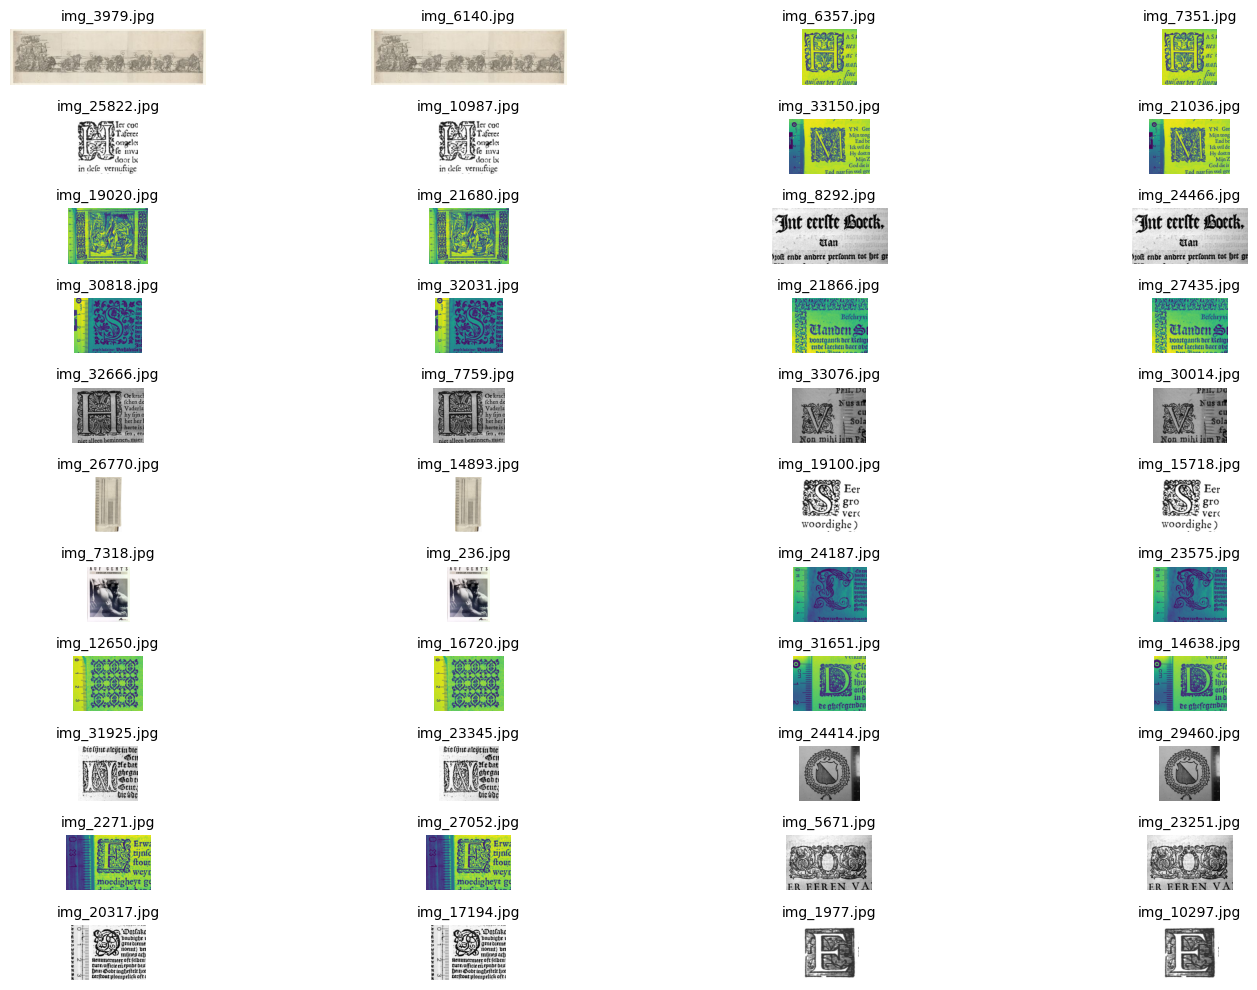

In [7]:
# Display duplicate images
if quality_report['duplicate_images']:
    print("\nDisplaying duplicate images:")
    # Flatten duplicate groups for display
    dup_images = []
    for dup_group in quality_report['duplicate_images']:  # First 2 groups
        for img_id in dup_group['image_ids']:
            dup_images.append({'id': img_id, 'hash': dup_group['hash'][:8]})

display_images_from_dict(dup_images, images_per_row=4, title_key='id')


In [8]:
# Get target labels for duplicate images
print("TARGET LABELS FOR DUPLICATE IMAGES")
print("=" * 60)

for dup_group in quality_report['duplicate_images']:
    print(f"\nDuplicate group (Hash: {dup_group['hash'][:8]}...):")
    print(f"  Count: {dup_group['count']} identical images")

    # Get target labels for each image in the duplicate group
    for img_id in dup_group['image_ids']:
        # Find the target label in the dataframe
        target = df[df['id'] == img_id]['target'].values

        if len(target) > 0:
            print(f"    {img_id} -> Target: {target[0]}")
        else:
            print(f"    {img_id} -> Target: NOT FOUND")

# Summary: Check if duplicates have same or different labels
print("\n" + "=" * 60)
print("DUPLICATE LABEL CONSISTENCY CHECK")
print("=" * 60)

for dup_group in quality_report['duplicate_images']:
    targets = []
    for img_id in dup_group['image_ids']:
        target = df[df['id'] == img_id]['target'].values
        if len(target) > 0:
            targets.append(target[0])

    unique_targets = set(targets)

    if len(unique_targets) > 1:
        print(f"⚠️  INCONSISTENT LABELS - Images: {dup_group['image_ids']}")
        print(f"    Labels: {targets}")
    else:
        print(f"✓  Consistent labels ({list(unique_targets)[0]}) - {len(targets)} images")

TARGET LABELS FOR DUPLICATE IMAGES

Duplicate group (Hash: 6bbd924e...):
  Count: 2 identical images
    img_3979.jpg -> Target: class5
    img_6140.jpg -> Target: class5

Duplicate group (Hash: ed56336a...):
  Count: 2 identical images
    img_6357.jpg -> Target: class5
    img_7351.jpg -> Target: class5

Duplicate group (Hash: c082a5a8...):
  Count: 2 identical images
    img_25822.jpg -> Target: class5
    img_10987.jpg -> Target: class5

Duplicate group (Hash: 107ccac6...):
  Count: 2 identical images
    img_33150.jpg -> Target: class5
    img_21036.jpg -> Target: class5

Duplicate group (Hash: 4ac599c4...):
  Count: 2 identical images
    img_19020.jpg -> Target: class5
    img_21680.jpg -> Target: class5

Duplicate group (Hash: b8590607...):
  Count: 2 identical images
    img_8292.jpg -> Target: class5
    img_24466.jpg -> Target: class5

Duplicate group (Hash: 98dc4a5e...):
  Count: 2 identical images
    img_30818.jpg -> Target: class5
    img_32031.jpg -> Target: class5

Dup

In [9]:
# 4. Brightness Analysis
print("\n4. BRIGHTNESS AND CONTRAST ANALYSIS")
print("-" * 60)

brightness_scores = []
variance_scores = []

for row in accessible_images:  # Sample for analysis
    image_path = os.path.join(IMG_DIR, row['id'])

    try:
        with Image.open(image_path) as img:
            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Calculate statistics
            stat = ImageStat.Stat(img)

            # Mean brightness (average of RGB channels)
            mean_brightness = sum(stat.mean) / len(stat.mean)
            brightness_scores.append(mean_brightness)

            # Variance (indicates contrast)
            mean_variance = sum(stat.var) / len(stat.var)
            variance_scores.append(mean_variance)

            # Check for extreme cases
            if mean_brightness < 30:  # Very dark
                quality_report['extreme_darkness'].append({
                    'id': row['id'],
                    'class': row.get('target', 'unknown'),
                    'brightness': mean_brightness
                })
            elif mean_brightness > 225:  # Very bright
                quality_report['extreme_brightness'].append({
                    'id': row['id'],
                    'class': row.get('target', 'unknown'),
                    'brightness': mean_brightness
                })

            # Check for very low variance (potentially blank/uniform images)
            if mean_variance < 100:
                quality_report['low_variance_images'].append({
                    'id': row['id'],
                    'class': row.get('target', 'unknown'),
                    'variance': mean_variance
                })
    except:
        continue

if brightness_scores:
    print(f"Brightness statistics (0-255 scale):")
    print(f"  Mean: {np.mean(brightness_scores):.2f}")
    print(f"  Std: {np.std(brightness_scores):.2f}")
    print(f"  Min: {np.min(brightness_scores):.2f}")
    print(f"  Max: {np.max(brightness_scores):.2f}")
    print(f"\nExtremely dark images (brightness < 30): {len(quality_report['extreme_darkness'])}")
    print(f"Extremely bright images (brightness > 225): {len(quality_report['extreme_brightness'])}")
    print(f"Low variance images (variance < 100): {len(quality_report['low_variance_images'])}")



4. BRIGHTNESS AND CONTRAST ANALYSIS
------------------------------------------------------------
Brightness statistics (0-255 scale):
  Mean: 162.20
  Std: 35.06
  Min: 26.83
  Max: 241.89

Extremely dark images (brightness < 30): 4
Extremely bright images (brightness > 225): 296
Low variance images (variance < 100): 37



Displaying darkest images:


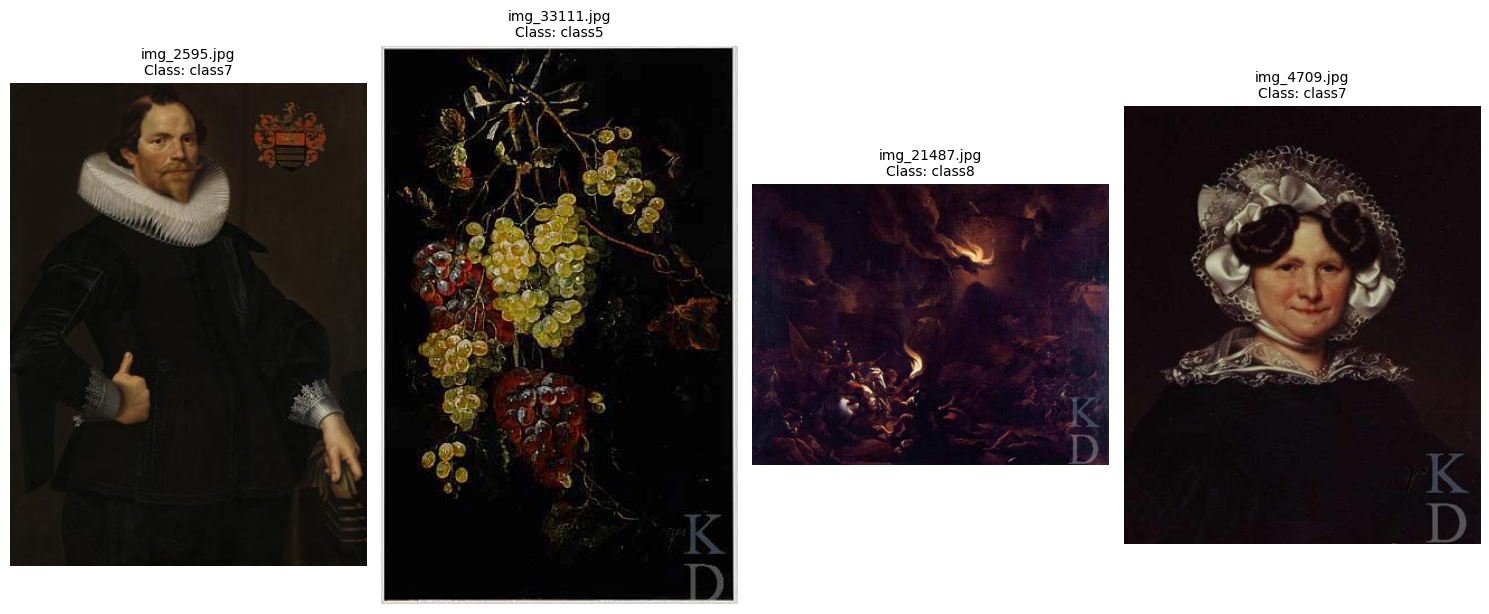

In [10]:
if quality_report['extreme_darkness']:
    print(f"\nDisplaying darkest images:")
    # Sort by brightness and show darkest ones
    sorted_dark = sorted(quality_report['extreme_darkness'],
                         key=lambda x: x['brightness'])[:16]
    display_images_from_dict(sorted_dark,
                             images_per_row=4,
                             title_key='id')


Displaying 296 bright images:


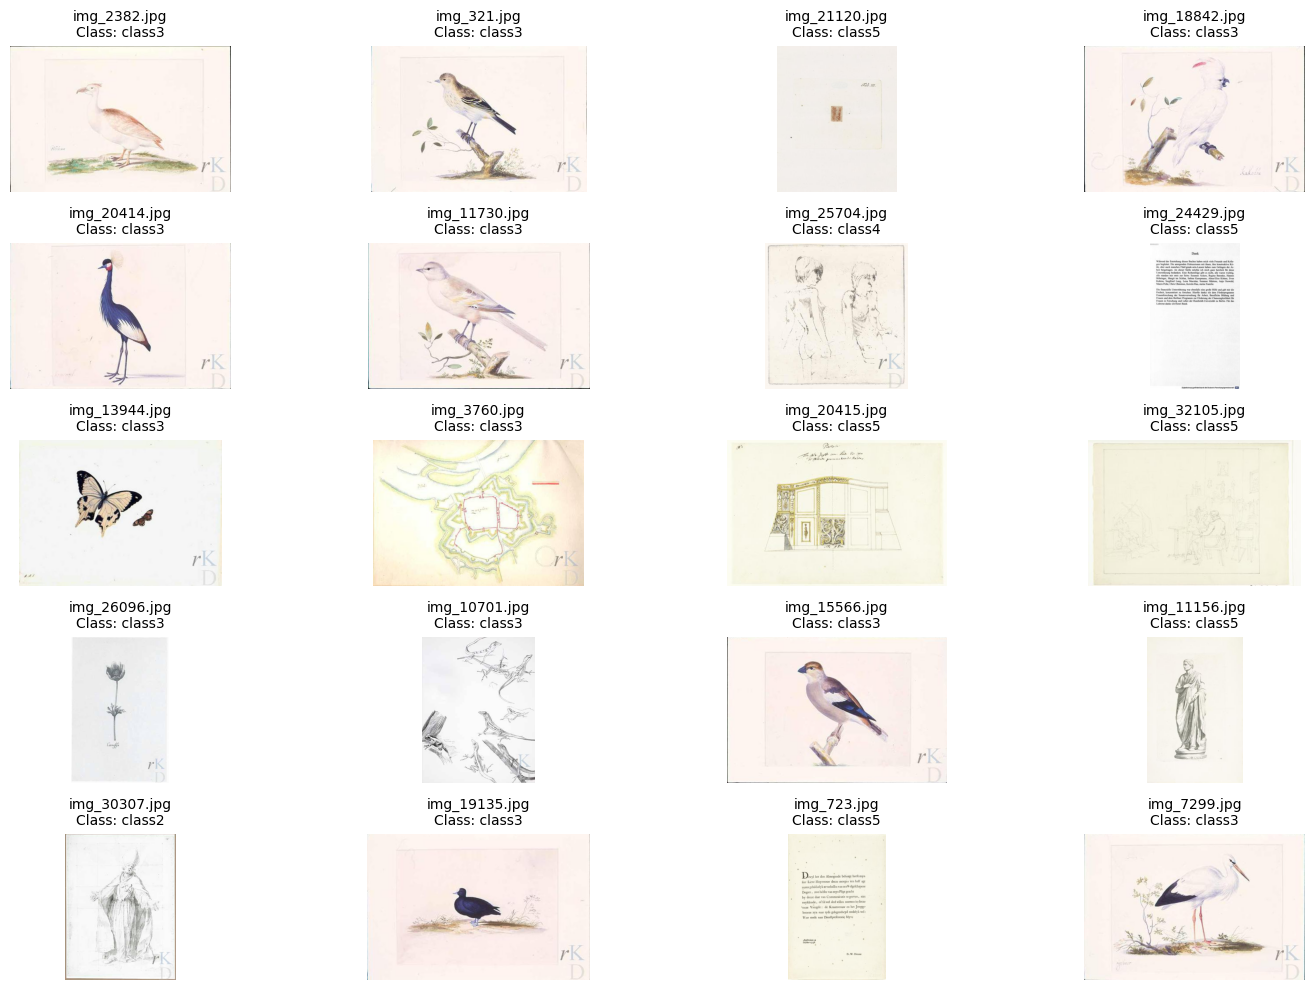

In [11]:
# Display extreme brightness images
if quality_report['extreme_brightness']:
    print(f"\nDisplaying {len(quality_report['extreme_brightness'])} bright images:")
    # Sort by brightness and show brightest ones
    sorted_bright = sorted(quality_report['extreme_brightness'],
                           key=lambda x: x['brightness'],
                           reverse=True)[20:40]
    display_images_from_dict(sorted_bright,
                             images_per_row=4,
                             title_key='id')
else:
    print("No bright images found in quality_report['extreme_brightness']")


Displaying 37 low variance images:


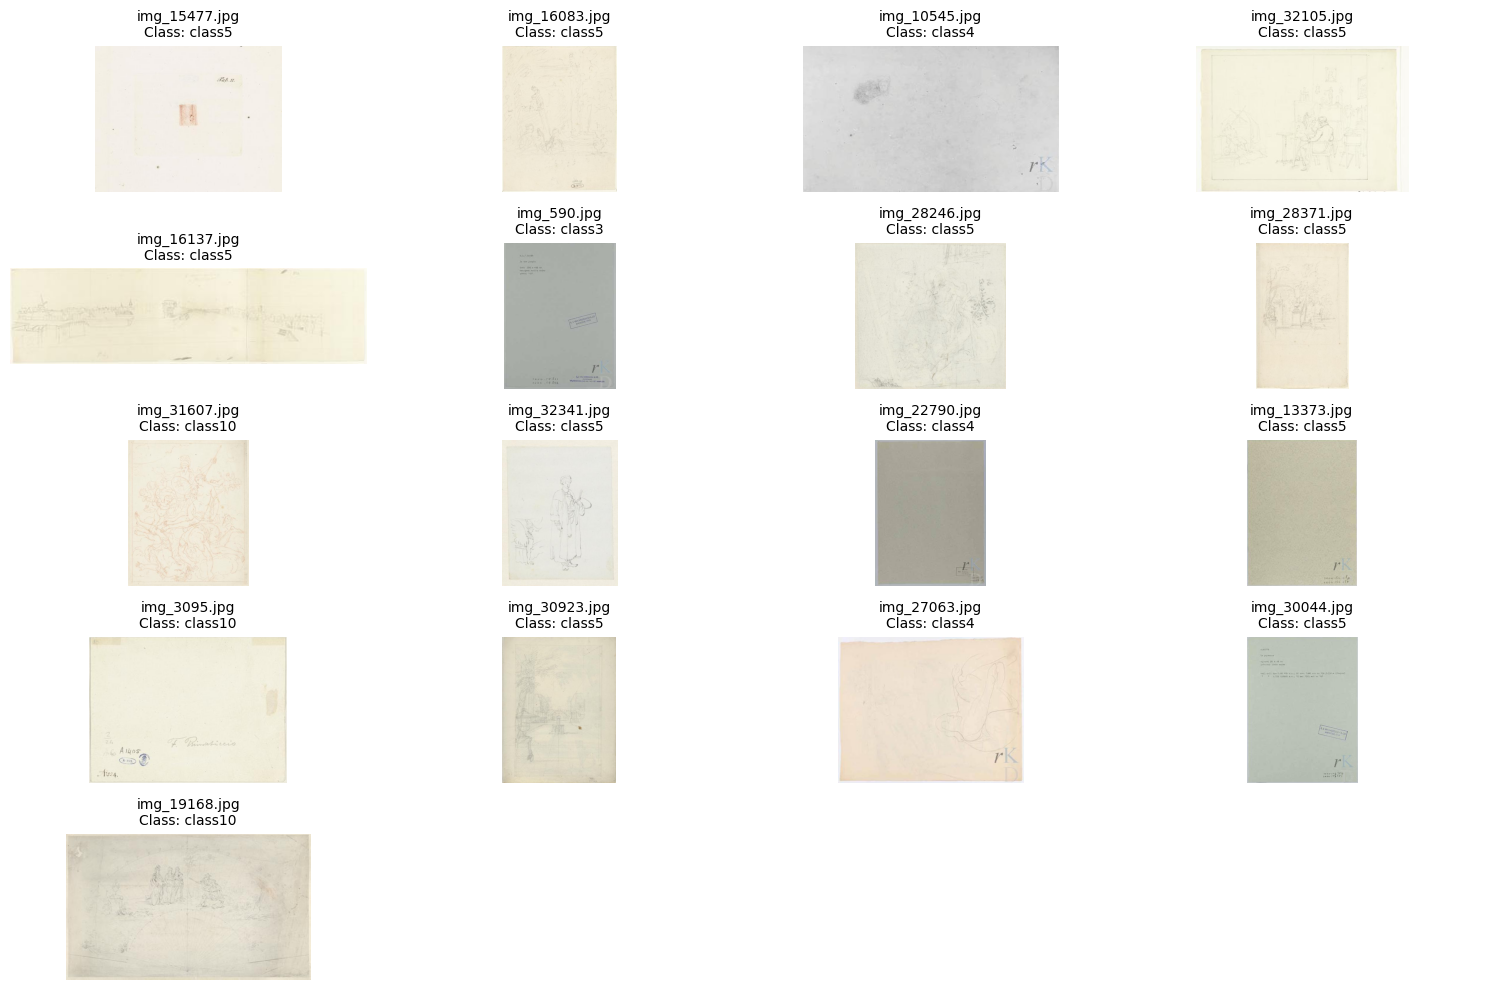

In [12]:
# Display low variance images
if quality_report['low_variance_images']:
    print(f"\nDisplaying {len(quality_report['low_variance_images'])} low variance images:")
    # Sort by variance and show lowest ones
    sorted_low_var = sorted(quality_report['low_variance_images'],
                            key=lambda x: x['variance'])[:-20]
    display_images_from_dict(sorted_low_var,
                             images_per_row=4,
                             title_key='id')
else:
    print("No low variance images found in quality_report['low_variance_images']")

In [13]:
# 5. Dimension Consistency Check
print("\n5. DIMENSION CONSISTENCY CHECK")
print("-" * 60)

dimension_counter = Counter()
mode_counter = Counter()

for row in accessible_images:
    image_path = os.path.join(IMG_DIR, row['id'])

    try:
        with Image.open(image_path) as img:
            dimension_counter[img.size] += 1
            mode_counter[img.mode] += 1
    except:
        continue

print(f"Unique dimension combinations: {len(dimension_counter)}")
print("\nMost common dimensions:")
for dim, count in dimension_counter.most_common(5):
    print(f"  {dim[0]}x{dim[1]}: {count} images ({count/sum(dimension_counter.values())*100:.1f}%)")

print("\nColor modes:")
for mode, count in mode_counter.most_common():
    print(f"  {mode}: {count} images ({count/sum(mode_counter.values())*100:.1f}%)")

# Identify unusual dimensions (very small or very large)
for dim, count in dimension_counter.items():
    width, height = dim
    if width < 32 or height < 32:
        quality_report['unusual_dimensions'].append({
            'dimension': dim,
            'count': count,
            'issue': 'too_small'
        })
    elif width > 2000 or height > 2000:
        quality_report['unusual_dimensions'].append({
            'dimension': dim,
            'count': count,
            'issue': 'too_large'
        })

if quality_report['unusual_dimensions']:
    print("\nUnusual dimensions detected:")
    for item in quality_report['unusual_dimensions']:
        print(f"  {item['dimension']}: {item['count']} images ({item['issue']})")

# 6. File Format Check
print("\n6. FILE FORMAT CHECK")
print("-" * 60)

format_counter = Counter()

for row in accessible_images:
    image_path = os.path.join(IMG_DIR, row['id'])

    try:
        with Image.open(image_path) as img:
            format_counter[img.format] += 1
    except Exception as e:
        quality_report['file_format_issues'].append({
            'id': row['id'],
            'error': str(e)
        })

print("File formats:")
for fmt, count in format_counter.most_common():
    print(f"  {fmt}: {count} images ({count/sum(format_counter.values())*100:.1f}%)")

if quality_report['file_format_issues']:
    print(f"\nFile format issues: {len(quality_report['file_format_issues'])}")


5. DIMENSION CONSISTENCY CHECK
------------------------------------------------------------
Unique dimension combinations: 1298

Most common dimensions:
  500x437: 1760 images (5.8%)
  500x375: 710 images (2.3%)
  336x500: 262 images (0.9%)
  341x500: 234 images (0.8%)
  328x500: 197 images (0.6%)

Color modes:
  RGB: 28297 images (93.2%)
  L: 2066 images (6.8%)

6. FILE FORMAT CHECK
------------------------------------------------------------
File formats:
  JPEG: 30363 images (100.0%)


In [14]:
# 7. Summary Report
print("\n" + "="*80)
print("DATA QUALITY SUMMARY")
print("="*80)

total_issues = sum([
    len(quality_report['missing_files']),
    len(quality_report['corrupted_images']),
    len(quality_report['duplicate_images']),
    len(quality_report['extreme_brightness']),
    len(quality_report['extreme_darkness']),
    len(quality_report['low_variance_images']),
    len(quality_report['unusual_dimensions']),
    len(quality_report['file_format_issues'])
])

print(f"\nTotal quality issues detected: {total_issues}")
print("\nBreakdown:")
print(f"  Missing files: {len(quality_report['missing_files'])}")
print(f"  Corrupted images: {len(quality_report['corrupted_images'])}")
print(f"  Duplicate groups: {len(quality_report['duplicate_images'])}")
print(f"  Extremely dark images: {len(quality_report['extreme_darkness'])}")
print(f"  Extremely bright images: {len(quality_report['extreme_brightness'])}")
print(f"  Low variance images: {len(quality_report['low_variance_images'])}")
print(f"  Unusual dimensions: {len(quality_report['unusual_dimensions'])}")
print(f"  File format issues: {len(quality_report['file_format_issues'])}")

# 8. Recommendations
print("\n" + "="*80)
print("QUALITY-BASED RECOMMENDATIONS")
print("="*80)

recommendations = []

if quality_report['missing_files']:
    recommendations.append("• Remove or handle missing file entries from dataset")

if quality_report['corrupted_images']:
    recommendations.append("• Exclude corrupted images from training")

if quality_report['duplicate_images']:
    recommendations.append("• Remove duplicate images to prevent data leakage")

if len(quality_report['extreme_darkness']) > 10:
    recommendations.append("• Apply histogram equalization or CLAHE to dark images")
    recommendations.append("• Consider removing extremely dark images if uninformative")

if len(quality_report['extreme_brightness']) > 10:
    recommendations.append("• Normalize or clip extremely bright images")

if len(quality_report['low_variance_images']) > 10:
    recommendations.append("• Investigate low variance images - may be blank/corrupted")
    recommendations.append("• Consider removing if they don't contain useful information")

if len(dimension_counter) > 5:
    most_common_dim = dimension_counter.most_common(1)[0][0]
    recommendations.append(f"• Resize all images to consistent dimensions: {most_common_dim}")

if len(mode_counter) > 1:
    recommendations.append("• Convert all images to consistent color mode (RGB recommended)")

if not recommendations:
    recommendations.append("• Dataset quality is good - proceed with standard preprocessing")

for rec in recommendations:
    print(rec)



DATA QUALITY SUMMARY

Total quality issues detected: 359

Breakdown:
  Missing files: 0
  Corrupted images: 0
  Duplicate groups: 22
  Extremely dark images: 4
  Extremely bright images: 296
  Low variance images: 37
  Unusual dimensions: 0
  File format issues: 0

QUALITY-BASED RECOMMENDATIONS
• Remove duplicate images to prevent data leakage
• Normalize or clip extremely bright images
• Investigate low variance images - may be blank/corrupted
• Consider removing if they don't contain useful information
• Resize all images to consistent dimensions: (500, 437)
• Convert all images to consistent color mode (RGB recommended)


In [15]:
print("=" * 80)
print("CREATING CLEANED DATASET - REMOVING DUPLICATES")
print("=" * 80)

# Start with a copy of the original dataframe
df_cleaned = df.copy()

print(f"\nOriginal dataset size: {len(df_cleaned)}")

# Collect all duplicate image IDs to remove (keep first instance)
images_to_remove = []

for dup_group in quality_report['duplicate_images']:
    # Keep the first image, remove the rest
    image_ids = dup_group['image_ids']
    images_to_keep = image_ids[0]
    images_to_remove.extend(image_ids[1:])  # Remove all except first

    print(f"\nDuplicate group:")
    print(f"  Keeping: {images_to_keep}")
    print(f"  Removing: {image_ids[1:]}")

print(f"\nTotal duplicate images to remove: {len(images_to_remove)}")

# Remove duplicate images from dataframe
df_cleaned = df_cleaned[~df_cleaned['id'].isin(images_to_remove)]

print(f"Cleaned dataset size: {len(df_cleaned)}")
print(f"Images removed: {len(df) - len(df_cleaned)}")


CREATING CLEANED DATASET - REMOVING DUPLICATES

Original dataset size: 30363

Duplicate group:
  Keeping: img_3979.jpg
  Removing: ['img_6140.jpg']

Duplicate group:
  Keeping: img_6357.jpg
  Removing: ['img_7351.jpg']

Duplicate group:
  Keeping: img_25822.jpg
  Removing: ['img_10987.jpg']

Duplicate group:
  Keeping: img_33150.jpg
  Removing: ['img_21036.jpg']

Duplicate group:
  Keeping: img_19020.jpg
  Removing: ['img_21680.jpg']

Duplicate group:
  Keeping: img_8292.jpg
  Removing: ['img_24466.jpg']

Duplicate group:
  Keeping: img_30818.jpg
  Removing: ['img_32031.jpg']

Duplicate group:
  Keeping: img_21866.jpg
  Removing: ['img_27435.jpg']

Duplicate group:
  Keeping: img_32666.jpg
  Removing: ['img_7759.jpg']

Duplicate group:
  Keeping: img_33076.jpg
  Removing: ['img_30014.jpg']

Duplicate group:
  Keeping: img_26770.jpg
  Removing: ['img_14893.jpg']

Duplicate group:
  Keeping: img_19100.jpg
  Removing: ['img_15718.jpg']

Duplicate group:
  Keeping: img_7318.jpg
  Removing:

In [16]:
print("=" * 80)
print("REMOVING LOW VARIANCE IMAGES")
print("=" * 80)

print(f"\nCurrent dataset size: {len(df_cleaned)}")
print(f"Low variance images detected: {len(quality_report['low_variance_images'])}")

# Extract IDs of low variance images
low_variance_ids = [item['id'] for item in quality_report['low_variance_images']]

# Show some statistics about what we're removing
print("\nLow variance image statistics:")
print(f"  Lowest variance: {min(quality_report['low_variance_images'], key=lambda x: x['variance'])['variance']:.2f}")
print(
    f"  Highest variance (of low var images): {max(quality_report['low_variance_images'], key=lambda x: x['variance'])['variance']:.2f}")

# Check class distribution of low variance images
if 'target' in df.columns:
    low_var_classes = df_cleaned[df_cleaned['id'].isin(low_variance_ids)]['target'].value_counts()
    print("\nClass distribution of low variance images to be removed:")
    print(low_var_classes)

# Remove low variance images from cleaned dataframe
df_cleaned = df_cleaned[~df_cleaned['id'].isin(low_variance_ids)]

print(f"\nDataset size after removing low variance images: {len(df_cleaned)}")
print(f"Low variance images removed: {len(low_variance_ids)}")



REMOVING LOW VARIANCE IMAGES

Current dataset size: 30341
Low variance images detected: 37

Low variance image statistics:
  Lowest variance: 29.67
  Highest variance (of low var images): 98.74

Class distribution of low variance images to be removed:
target
class5     20
class4      7
class10     4
class7      3
class3      2
class2      1
Name: count, dtype: int64

Dataset size after removing low variance images: 30304
Low variance images removed: 37


In [20]:
df_cleaned

,id,target,split,target_class
0,img_18626.jpg,class4,train,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
1,img_13776.jpg,class5,train,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
2,img_22442.jpg,class2,train,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,img_12725.jpg,class5,train,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,img_181.jpg,class8,train,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
...,...,...,...,...
30358,img_9873.jpg,class8,test,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
30359,img_18158.jpg,class8,test,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
30360,img_10877.jpg,class7,test,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
30361,img_3022.jpg,class3,test,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [19]:
# Save updated cleaned dataset
output_path = '/home/ubuntu/deep_learning_exam1/excel/train_test_cleaned.xlsx'
df_cleaned.to_excel(output_path, index=False)

print(f"\n✓ Updated cleaned dataset saved to: {output_path}")

# Final verification
print("\n" + "-" * 60)
print("FINAL VERIFICATION")
print("-" * 60)
print(f"Original dataset rows: {len(df)}")
print(f"Final cleaned rows: {len(df_cleaned)}")
print(f"Total images removed: {len(df) - len(df_cleaned)}")
print(f"  - Duplicates removed: {len(images_to_remove)}")
print(f"  - Low variance removed: {len(low_variance_ids)}")

# Check final class distribution
if 'target' in df.columns:
    print("\nFinal class distribution:")
    print(df_cleaned['target'].value_counts().sort_index())

    print("\nClass distribution comparison:")
    comparison = pd.DataFrame({
        'Original': df['target'].value_counts().sort_index(),
        'Cleaned': df_cleaned['target'].value_counts().sort_index()
    })
    comparison['Removed'] = comparison['Original'] - comparison['Cleaned']


✓ Updated cleaned dataset saved to: /home/ubuntu/deep_learning_exam1/excel/train_test_cleaned.xlsx

------------------------------------------------------------
FINAL VERIFICATION
------------------------------------------------------------
Original dataset rows: 30363
Final cleaned rows: 30304
Total images removed: 59
  - Duplicates removed: 22
  - Low variance removed: 37

Final class distribution:
target
class1        24
class10      834
class2      2619
class3      4998
class4      1372
class5     12773
class6        72
class7      1347
class8      5218
class9      1047
Name: count, dtype: int64

Class distribution comparison:
